Non-Stacked


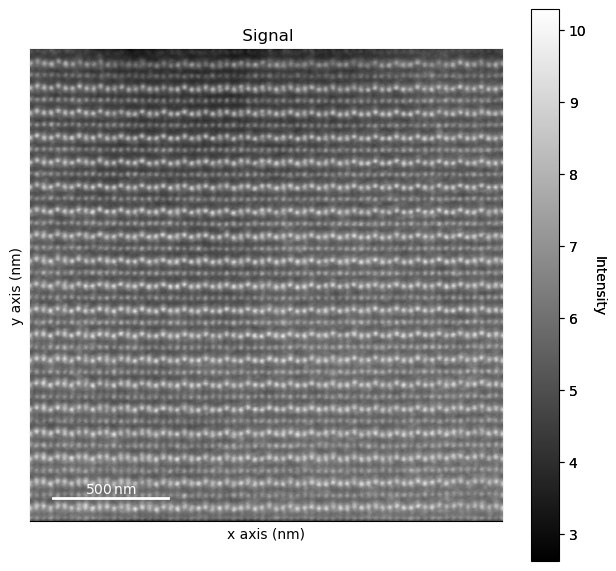

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('../..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
s_load = hs.load('../../data/images/Jaume LFO/HAADF_Buena.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

In [2]:
import scipy.signal
import numpy as np

left_bound = 100 # TUNE THIS
right_bound = 2048-100 # TUNE THIS
start_pixel = 100 # TUNE THIS
end_pixel = 2048-100 # TUNE THIS

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)

In [3]:
crop.build_grid_dict()
crop.get_atom_positions()
# crop.refine_atom_positions()

crop.get_nn_intensities()
crop.get_nn_displacements()
crop.get_atom_types()

In [4]:
from sklearn.decomposition import PCA

def get_intensity_pca(crop, atom_type='Lu', n_components=4):

    intensity_vectors = []
    for patch in crop.grid.values():
        if patch.nn_intensity_differences is not None and patch.atom_type == atom_type:
            intensity_vectors.append(patch.nn_intensity_differences)

    X = np.array(intensity_vectors)
    pca = PCA(n_components=n_components) 
    pca.fit(X)
    scores = pca.transform(X)
    return X, pca, scores

def plot_pca_vectors(pca):
    feature_names = ['up', 'down', 'left', 'right']
    fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharey=True)
    axes = axes.flatten()

    for i in range(pca.n_components):
        ax = axes[i]
        components = pca.components_[i]
        ax.bar(feature_names, components)
        ax.set_title(f'PC {i+1} (Explains {pca.explained_variance_ratio_[i]:.1%} var)')
        ax.set_ylabel('Component Loading')
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    plt.tight_layout()
    plt.show()

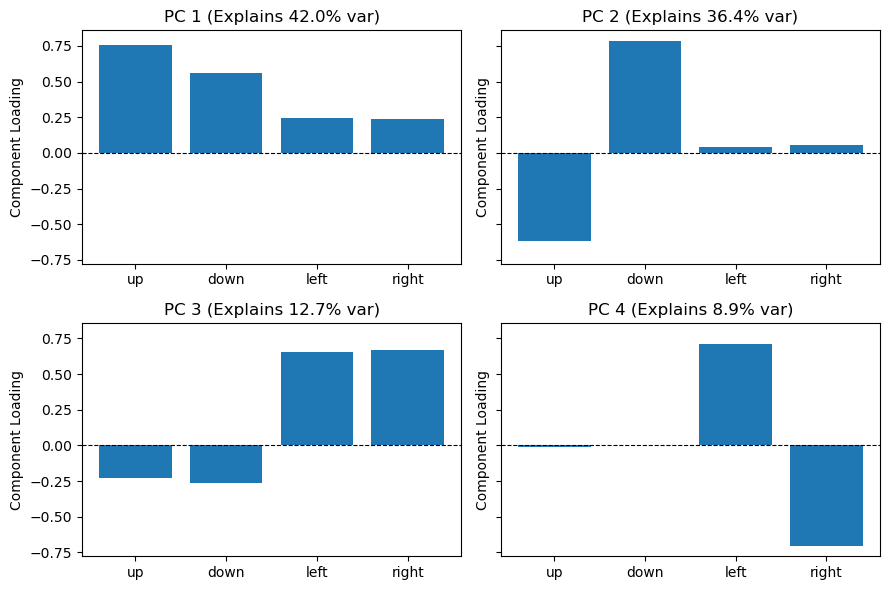

In [5]:
X, pca, scores = get_intensity_pca(crop, atom_type='Lu', n_components=4)
plot_pca_vectors(pca)

Simply looking at the intensity, PC3 specifically explains our intended intensity differences.

In [6]:
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def get_edges(patch):
        col_edges = patch.roi_col_edges
        row_edges = patch.roi_row_edges
        x0, x1 = float(col_edges[0]), float(col_edges[1])
        y0, y1 = float(row_edges[0]), float(row_edges[1])
        return x0, x1, y0, y1

def get_patch_score_map(crop, pca, atom_type='Lu'):
    valid_patches = []
    for patch in crop.grid.values():
        if (patch.nn_intensity_differences is not None 
            and patch.atom_type == atom_type):
            valid_patches.append(patch)
    
    scores = pca.fit_transform(X)
    patch_score_map = {patch: score for patch, score in zip(valid_patches, scores)}
    return patch_score_map

def plot_pca_grid(crop, pca, pc_component, atom_type='Lu'):
    patch_score_map = get_patch_score_map(crop, pca, atom_type)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(crop.roi, cmap='gray', alpha=0.5)
    max_abs = np.max(np.abs([score[pc_component] for score in patch_score_map.values()]))
    norm = mcolors.Normalize(vmin=-max_abs, vmax=max_abs)
    cmap = plt.get_cmap('bwr')

    def _draw_box(patch, color, fill, z):
        edges = get_edges(patch)
        if edges is None: return
        x0, x1, y0, y1 = edges
        wr = x1 - x0
        hr = y1 - y0
        rect = Rectangle((x0, y0), wr, hr, edgecolor=color, facecolor=color, 
                         fill=fill, linewidth=1, alpha=0.8, zorder=z)
        ax.add_patch(rect)

    for patch in patch_score_map:
        score = patch_score_map[patch][pc_component]
        color = cmap(norm(score))
        _draw_box(patch, color=color, fill=True, z=2)

    explained_var = pca.explained_variance_ratio_[pc_component]
    ax.set_title(f'Spatial Map of PC {pc_component} (Explains {explained_var:.1%} var)\nAtom Type: {atom_type}')
    
    # Add Colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label(f'PC {pc_component} Score (Deviation from Mean)')

    ax.set_xlabel('i (x)')
    ax.set_ylabel('j (y)')
    plt.tight_layout()
    plt.show()

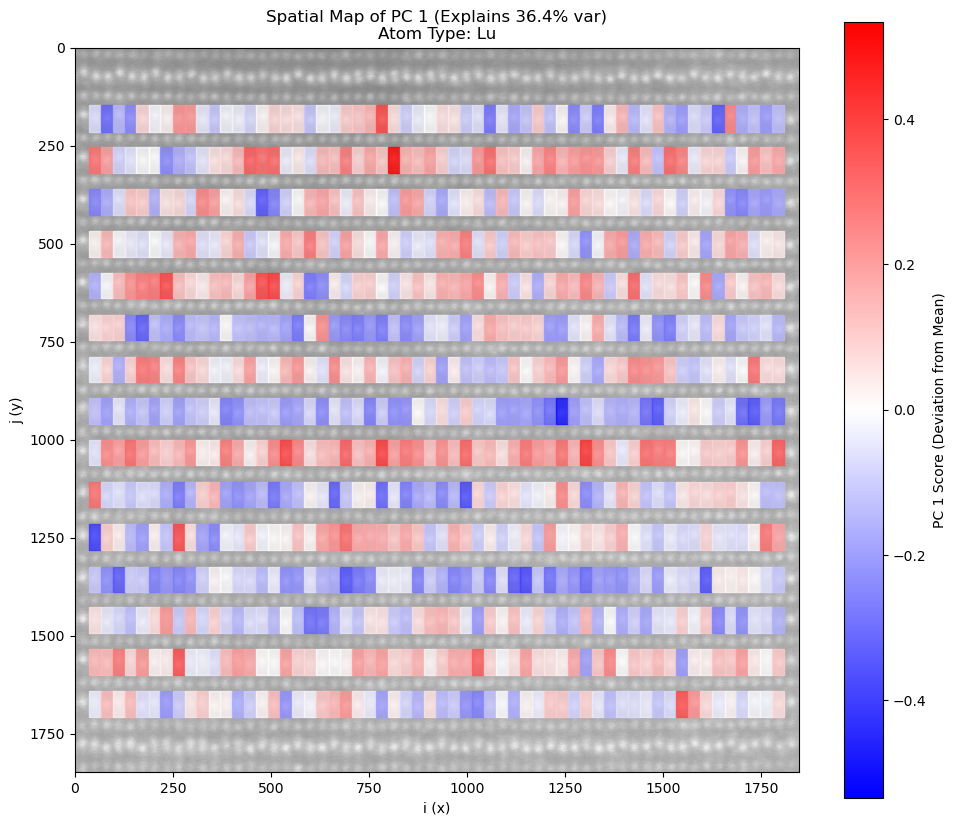

In [52]:
plot_pca_grid(crop, pca, pc_component=1, atom_type='Lu')

In [8]:
def plot_indexed_patches(crop, patch):
    if patch.nn_intensity_differences is None:
        print("The patch at the given indices does not have valid nn_intensity_differences.")
        return

    i, j = patch.index
    up_bound = crop.grid[i, j-1].roi_row_edges[0]
    low_bound = crop.grid[i, j+1].roi_row_edges[1]
    left_bound = crop.grid[i-1, j].roi_col_edges[0]
    right_bound = crop.grid[i+1, j].roi_col_edges[1]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(crop.roi.isig[left_bound:right_bound, up_bound:low_bound], cmap='gray')
    ax.set_title(f'Highlighted Patches by Indices')
    ax.set_xlabel('i (x)')
    ax.set_ylabel('j (y)')
    plt.tight_layout()
    plt.show()

In [41]:
patch_score_map = get_patch_score_map(crop, pca, atom_type='Lu')
results = [
    [patch, score] for patch, score in patch_score_map.items() 
    if score[2] > 0.2
]
results = np.array(results, dtype=object)

if results.shape[0] != 0:
    scores = results[:, 1]
    print(scores)

[array([ 0.04417951, -0.14260499,  0.21151978, -0.00481297])
 array([-0.00543526, -0.20107478,  0.20659281, -0.14222038])
 array([-0.21261093, -0.05645687,  0.28308205,  0.03170696])
 array([ 0.3319287 ,  0.18850166,  0.22598494, -0.24029551])
 array([-0.19638881, -0.18990816,  0.26445245,  0.12959319])
 array([-0.12242707,  0.06646808,  0.23010297,  0.01892029])
 array([-0.1802133 , -0.05442609,  0.23063814, -0.0534808 ])
 array([ 0.03141829,  0.34922893,  0.22572943, -0.00254748])
 array([ 0.19003904, -0.10927793,  0.20225684, -0.02280081])
 array([0.25149282, 0.03153077, 0.22223821, 0.12700134])
 array([0.26881804, 0.20221429, 0.25158659, 0.01383926])
 array([0.25525444, 0.11330716, 0.2502842 , 0.05186158])
 array([-0.04425756,  0.12360855,  0.20813439, -0.04543379])
 array([ 0.13596637,  0.0858164 ,  0.2676185 , -0.20210505])]


[-0.36056519 -0.10241365  0.06579447  0.41137266]


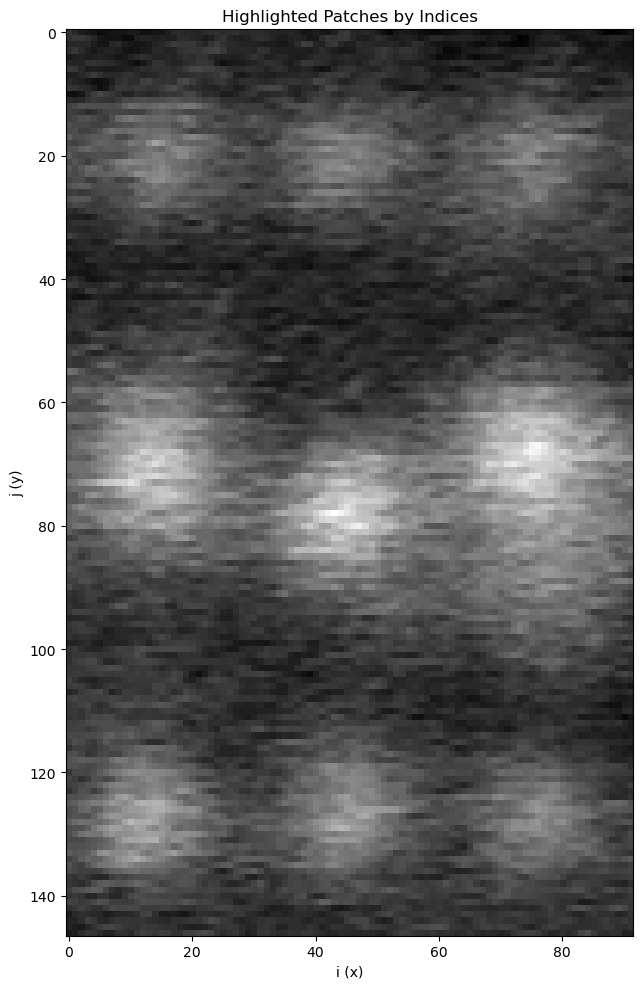

In [45]:
patches = results[:, 0]
idx = 3
print(patches[idx].nn_intensity_differences)
plot_indexed_patches(crop, patches[idx])